# Function calling

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/martasumyk/ai_practice/blob/main/01-Function_Calling/01_Function_Calling.ipynb
)

[![Open in GitHub](https://img.shields.io/badge/Open%20in-GitHub-black?logo=github)](
https://github.com/martasumyk/ai_practice/blob/main/01-Function_Calling/01_Function_Calling.ipynb
)

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch, json
from openai import OpenAI
import json
import requests, re
from requests.exceptions import RequestException
from google.colab import userdata
import os

Function Calling enables an AI model to detect tasks requiring external action and then trigger the appropriate tool or API. This process typically involves the following steps:

1. Detection: The AI model detects that a user query or task requires an action that it cannot perform on its own.

2. Function Selection: The model identifies the correct function or API that can fulfill the request.

3. Parameter Passing: The model sends the necessary parameters to the selected function.

4. Execution: The external tool or API processes the request and returns the results.

5. Response Integration: The AI integrates the returned data into its response to the user, often in real-time.

Source: https://finetunedb.com/blog/what-is-function-calling-simply-explained/

LLMs are powerful at understanding and generating text, but they’re not perfect at arithmetic.  
For example, when asked:

> “What is 234 + 456 + 789?”

the model might *guess* instead of computing accurately, because it doesn’t truly “calculate” — it predicts the most likely sequence of tokens.


To fix this, we can connect the LLM to external tools or functions that handle specific tasks.  
The model doesn’t have to know how to compute - it just needs to decide which tool to call  
and pass the right arguments.

This idea is called function calling or tool use.

In this seminar, we’ll:

1. Define a simple Python function that adds two numbers, multiplies them or reverses text.
2. Let an LLM decide when to call that function.
3. Show how the system integrates the result into the final response.

---


## Defining tools

Tools for adding two numbers, multiplying numbers or reversing the text:

In [2]:
def add_numbers(a: int, b: int) -> int:
    """Add two integers and return the sum."""
    return a + b

In [3]:
def multiply_numbers(a: int, b: int) -> int:
    """Multiply two integers and return the product."""
    return a * b

In [4]:
def reverse_text(text: str) -> str:
    """Return the reversed version of a string."""
    return text[::-1]

In [5]:
tools = {
    "add_numbers": add_numbers,
    "multiply_numbers": multiply_numbers,
    "reverse_text": reverse_text,
}

## Open-source (Mistral)

Usually, open-source models with open weights do not have built-in tool-calling capabilities; instead, external frameworks such as LangChain, LlamaIndex, OpenInterpreter, or custom wrappers must be used to add function calling.

Model used: https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2.

### Loading model

In [6]:
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")
model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2", torch_dtype=torch.float16, device_map="auto")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

### Prompts

In [7]:
prompt = """
You are a function-calling model.

Available functions:
1. add_numbers(a: int, b: int) -> int
2. multiply_numbers(a: int, b: int) -> int
3. reverse_text(text: str) -> str

Your job:
- Read the user request.
- Select the best matching function.
- Respond ONLY with a Python-style function call in this form:
    function_name(arg1=value,...)

Examples:
User: What is 5 + 7?
Model: add_numbers(a=5, b=7)

User: Multiply 9 and 11.
Model: multiply_numbers(a=9, b=11)

User: Reverse the phrase 'hello world'.
Model: reverse_text(text="hello world")

User: {USER_QUERY_HERE}
Model:
"""

Prompts for reversing text, adding numbers, multiplying numbers and other (checking the weather).

In [8]:
user_query_text = "Reverse this sentence: machine learning"
user_query_addition = "Add numbers 9 and 4"
user_query_multiplication = "Multiply numbers 9 and 4"
user_query_other = "Check the weather for today in Lviv"

Note: when checking the weather, the model must not call one of our tools (neither `add_numbers`, `multiply_numbers` nor `reverse_text`).

In [9]:
final_prompt_text = prompt.replace("{USER_QUERY_HERE}", user_query_text)
final_prompt_addition = prompt.replace("{USER_QUERY_HERE}", user_query_addition)
final_prompt_multiplication = prompt.replace("{USER_QUERY_HERE}", user_query_multiplication)
final_prompt_other = prompt.replace("{USER_QUERY_HERE}", user_query_other)

### Inference

In [11]:
out_text = model.generate(
    **tokenizer(final_prompt_text, return_tensors="pt").to(model.device),
    max_new_tokens=256
)

response_text = tokenizer.decode(out_text[0], skip_special_tokens=True)
print(response_text)

In [ ]:
out_addition = model.generate(
    **tokenizer(final_prompt_addition, return_tensors="pt").to(model.device),
    max_new_tokens=256
)

response_addition = tokenizer.decode(out_addition[0], skip_special_tokens=True)
print(response_addition)

In [ ]:
out_multiplication = model.generate(
    **tokenizer(final_prompt_multiplication, return_tensors="pt").to(model.device),
    max_new_tokens=256
)

response_multiplication = tokenizer.decode(out_multiplication[0], skip_special_tokens=True)
print(response_multiplication)

In [ ]:
out = model.generate(
    **tokenizer(final_prompt_other, return_tensors="pt").to(model.device),
    max_new_tokens=256
)

response_other = tokenizer.decode(out[0], skip_special_tokens=True)
print(response_other)

## Proprietary (OpenAI)

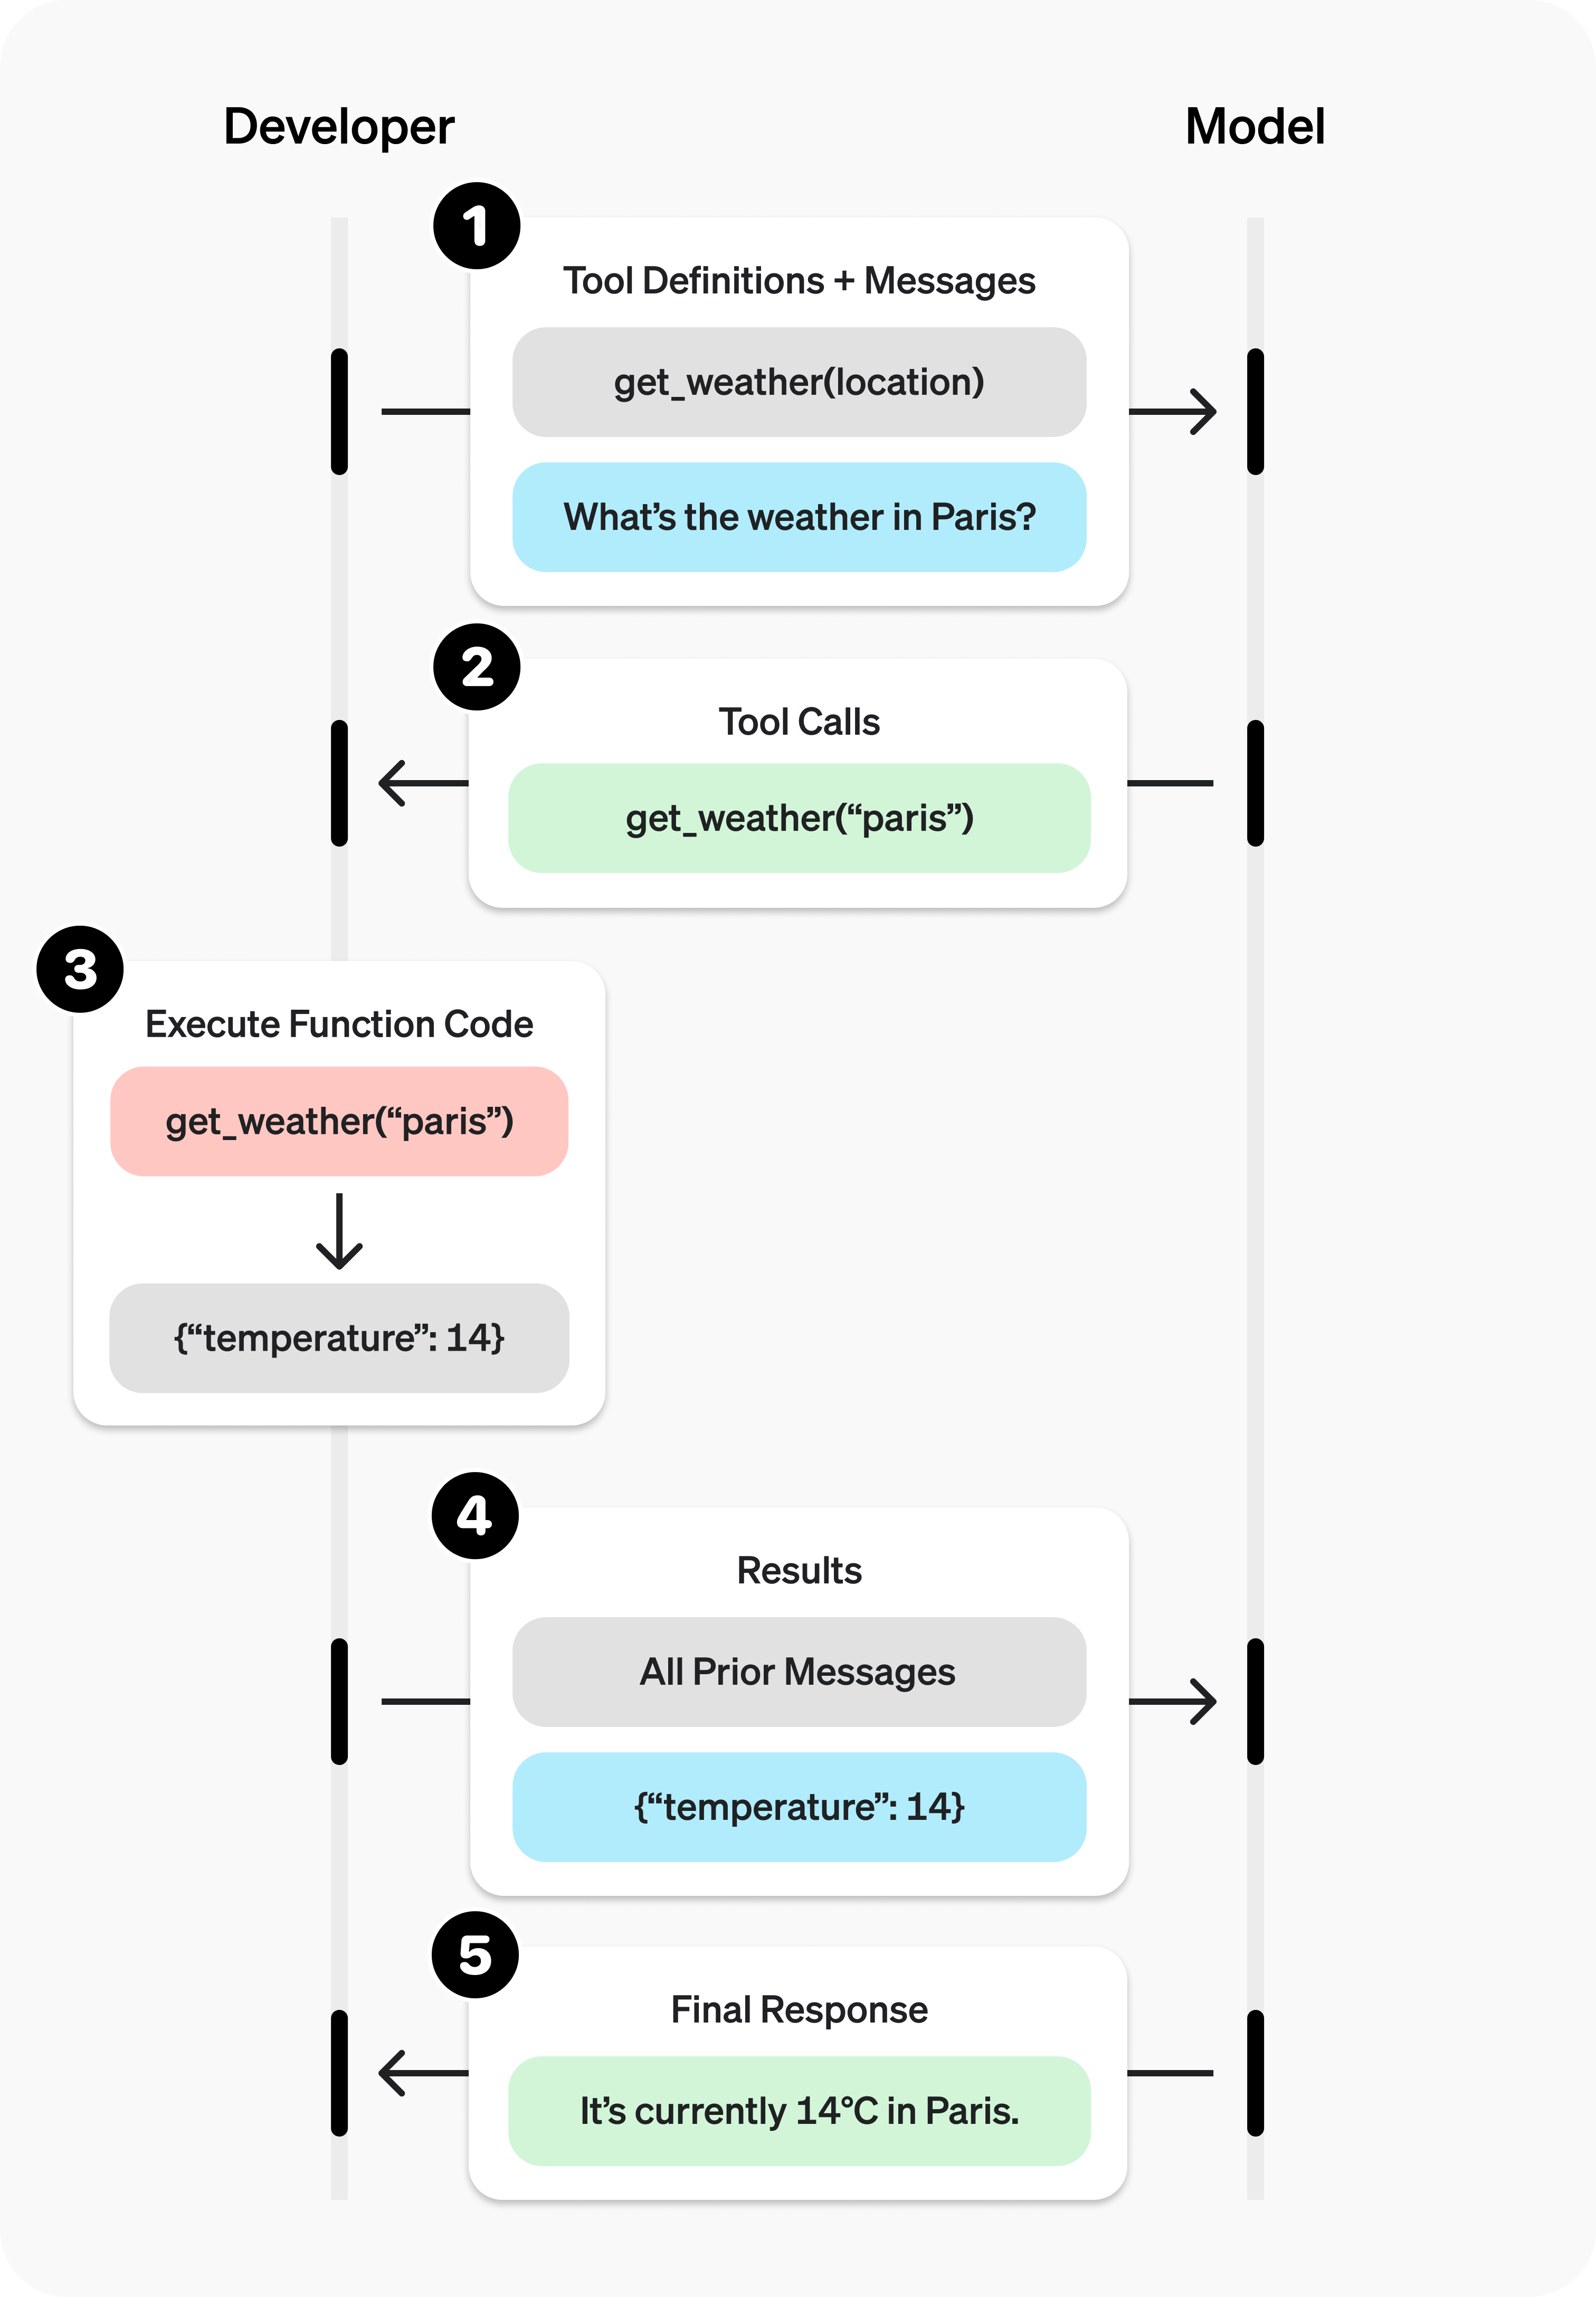

### Load OpenAI API key

In [12]:
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
client = OpenAI()

### Tools

Describe tools:

In [13]:
openai_tools = [
    {
        "type": "function",
        "function": {
            "name": "add_numbers",
            "description": "Add two integers and return the sum.",
            "parameters": {
                "type": "object",
                "properties": {
                    "a": {
                        "type": "integer",
                        "description": "First integer."
                    },
                    "b": {
                        "type": "integer",
                        "description": "Second integer."
                    }
                },
                "required": ["a", "b"]
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "multiply_numbers",
            "description": "Multiply two integers and return the product.",
            "parameters": {
                "type": "object",
                "properties": {
                    "a": {
                        "type": "integer",
                        "description": "First integer."
                    },
                    "b": {
                        "type": "integer",
                        "description": "Second integer."
                    }
                },
                "required": ["a", "b"]
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "reverse_text",
            "description": "Return the reversed version of a string.",
            "parameters": {
                "type": "object",
                "properties": {
                    "text": {
                        "type": "string",
                        "description": "Text to reverse."
                    }
                },
                "required": ["text"]
            },
        },
    },
]

### Helper

Helper that runs the model, executes tools, and returns the final answer:

In [14]:
def call_model_with_tools(user_query: str, model: str = "gpt-4o-mini") -> str:
    """
    1. Ask the model with our tools attached.
    2. If the model calls a tool, execute the Python function.
    3. Send tool result(s) back to the model.
    4. Return the final natural-language answer.
    """

    messages = [
        {
            "role": "system",
            "content": (
                "You are a function-calling model. "
                "Use the provided tools when they are helpful. "
                "If no tool matches (e.g., weather question), answer normally."
            ),
        },
        {"role": "user", "content": user_query},
    ]

    # 1) model chooses whether to call tools
    first_response = client.chat.completions.create(
        model=model,
        messages=messages,
        tools=openai_tools,
        tool_choice="auto",
    )

    first_message = first_response.choices[0].message

    if not first_message.tool_calls:
        return first_message.content

    messages.append(
        {
            "role": "assistant",
            "content": first_message.content,
            "tool_calls": first_message.tool_calls,
        }
    )

    for tool_call in first_message.tool_calls:
        tool_name = tool_call.function.name
        tool_args = json.loads(tool_call.function.arguments)

        if tool_name not in tools:
            tool_result = f"Error: unknown tool {tool_name}"
        else:
            py_function = tools[tool_name]
            tool_result = py_function(**tool_args)

        messages.append(
            {
                "role": "tool",
                "tool_call_id": tool_call.id,
                "name": tool_name,
                "content": json.dumps({"result": tool_result}),
            }
        )

    second_response = client.chat.completions.create(
        model=model,
        messages=messages,
    )

    final_message = second_response.choices[0].message
    return final_message.content


### Examples

In [15]:
user_query_text = "Reverse this sentence: machine learning"
user_query_addition = "Add numbers 9 and 4"
user_query_multiplication = "Multiply numbers 9 and 4"
user_query_other = "Check the weather for today in Lviv"

In [16]:
queries = [
    ("Reverse text", user_query_text),
    ("Addition", user_query_addition),
    ("Multiplication", user_query_multiplication),
    ("Other (weather)", user_query_other),
]

for label, q in queries:
    print("=" * 60)
    print(f"{label} | USER:", q)
    answer = call_model_with_tools(q)
    print("ASSISTANT:", answer)


Reverse text | USER: Reverse this sentence: machine learning
ASSISTANT: The reverse of the sentence "machine learning" is "gninrael enihcam".
Addition | USER: Add numbers 9 and 4
ASSISTANT: The sum of 9 and 4 is 13.
Multiplication | USER: Multiply numbers 9 and 4
ASSISTANT: The result of multiplying 9 and 4 is 36.
Other (weather) | USER: Check the weather for today in Lviv
ASSISTANT: I currently don't have the ability to check the weather. You can use a weather website or an app for up-to-date information on the weather in Lviv.
